In [4]:
import pandas as pd
import seaborn as sns
from collections import Counter
import nltk
nltk.download('stopwords')

# modelling
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score

# sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# udf
from functions import preprocess_tweets

[nltk_data] Downloading package stopwords to /home/noahs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initialise and inspect

In [5]:

# read in data
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',') # this should only be used for the submission
cols = train_data.columns

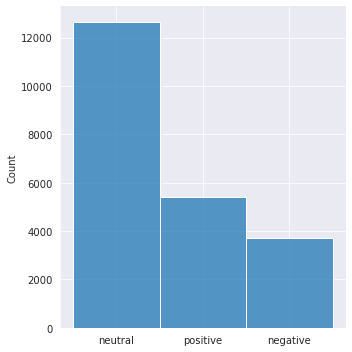

In [6]:
# Plot class distributions
sns.displot([x[0] for x in train_data[['sentiment']].values], discrete=True, bins=3)

In [7]:
# Extract raw training tweets from df
X_train_raw = [x[0] for x in train_data[['text']].values]

# Extract raw training sentiment data from df
Y_train = [x[0] for x in train_data[['sentiment']].values] # y training data

# Extract test tweets from test.csv/test_data df
X_test_raw = [x[0] for x in test_data[['text']].values]

print("Class distributions in Training set: ", Counter(Y_train))
print("Number of samples in Kaggle Testing set: ", len(X_test_raw))
print("Raw tweet example: {}\n with sentiment: ({})".format(X_train_raw[1], Y_train[1]))

Class distributions in Training set:  Counter({'neutral': 12659, 'positive': 5428, 'negative': 3715})
Number of samples in Kaggle Testing set:  6099
Raw tweet example:  is anybody going to the radio station tomorrow to see shawn? me and my friend may go but we would like to make new friends/meet there (:	
 with sentiment: (positive)


Data cleaning

In [8]:
# Clean the training and test data
X_train_clean = [preprocess_tweets(tweet) for tweet in X_train_raw] # X training data

# -> Kaggle Parts
X_test_clean = [preprocess_tweets(tweet) for tweet in X_test_raw] # for final submission on kaggle
# extract labels for future predictions
Y_test_labels = [x[0] for x in test_data[['id']].values]
# <- End Kaggle Parts

# inspect a cleaned tweet
print("Cleaned tweet example:\n {}\nwith sentiment: ({})".format(X_train_clean[1], Y_train[1]))

Cleaned tweet example:
 anybodi go radio station tomorrow see shawn friend may go would like make new friend meet emojismil
with sentiment: (positive)


Initialise Classifiers

In [9]:
LR = LogisticRegression(random_state=1, C=1.0, max_iter=2000)
RFC = RandomForestClassifier(random_state=1, criterion='gini', n_estimators=100)
LSVC = LinearSVC(C=0.1)
MNB = MultinomialNB(alpha=1)

# TODO: remove this f i dont use it
LR_base = LogisticRegression(random_state=1, C=1.0, max_iter=2000)
RFC_base = RandomForestClassifier(random_state=1, criterion='gini', n_estimators=100)
LSVC_base = LinearSVC(C=0.1)
MNB_base = MultinomialNB(alpha=1)

estimators = [('lr',LR),
              ('rf', RFC),
              ('lsvc', LSVC),
              ('mnb', MNB)]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
ensemble_clf = VotingClassifier(estimators=estimators)


Grid Search for best parameters - performed using BoW

In [10]:
# from sklearn.model_selection import GridSearchCV
#
# params = {'lr__C': [1.0, 50.0, 100.0],
#            'lr__max_iter':[1000, 2000],
#            'rf__n_estimators': [20, 100],
#            'lsvc__C': [0.1, 0.5, 1],
#            'mnb__alpha': [0.00001, 1]}
#
# # grid search the best parameters for the Majority Voting classifier
# grid = GridSearchCV(estimator=ensemble_clf, param_grid=params, cv=2, scoring='accuracy'
# verbose=3)
# grid.fit(X_train_bow, Y_train)
#
# # print best params from grid search
# grid.cv_results_['params'][grid.best_index_]

Ensemble/Stacking Method using BoW - No oversampling/undersampling - Scoring = Accuracy

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

# Vectorize the training and test data using BoW approach
vec_bow = CountVectorizer(ngram_range=(1, 2))
vec_bow.fit(X_train_clean)
X_train_bow = vec_bow.transform(X_train_clean)
X_test_bow = vec_bow.transform(X_test_clean)

In [12]:
# for clf, label in zip([ensemble_clf, stacking_clf], ['Majority Voting', 'Stacking']):
#     scores =cross_val_score(clf, X_train_bow, Y_train, scoring='accuracy', cv=2, n_jobs=-1)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s] (BoW)" % (scores.mean(), scores.std(), label))

Ensemble/Stacking Method using Tfid - No oversampling/undersampling - Scoring = Accuracy #TODO remove this

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

# Vectorize the training and test data
vec_tfid = TfidfVectorizer(use_idf = True,
                           ngram_range=(1, 2),
                           sublinear_tf=True)

vec_tfid.fit(X_train_clean)
X_train_Tfid = vec_tfid.transform(X_train_clean)
X_test_Tfid = vec_tfid.transform(X_test_clean)

In [14]:
# for clf, label in zip([ensemble_clf, stacking_clf], ['Majority Voting', 'Stacking']):
#     scores =cross_val_score(clf, X_train_Tfid, Y_train, scoring='accuracy', cv=2, n_jobs=-1)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s] (Tfid)" % (scores.mean(), scores.std(), label))

Accuracy scores for classifiers performance LR, RFC, LSVC, MNB - BoW

In [ ]:
for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf], ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes', 'Majority Voting', 'Stacking']):
    scores =cross_val_score(clf, X_train_bow, Y_train, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (BoW)" % (scores.mean(), scores.std(), label))

Accuracy: 0.63 (+/- 0.00) [Random Forest Classifier] (BoW)
Accuracy: 0.65 (+/- 0.01) [Logistic Regression] (BoW)
Accuracy: 0.65 (+/- 0.01) [Linear SVM] (BoW)
Accuracy: 0.63 (+/- 0.00) [Multinominal Naive Bayes] (BoW)
Accuracy: 0.65 (+/- 0.01) [Majority Voting] (BoW)


Accuracy scores for classifiers performance LR, RFC, LSVC, MNB - Tfid

In [ ]:
for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf], ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes', 'Majority Voting', 'Stacking']):
    scores =cross_val_score(clf, X_train_bow, Y_train, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (Tfid)" % (scores.mean(), scores.std(), label))

Undersample from the dataset's majority class

In [ ]:
# reshape to fix index
X_train_clean_reshape = pd.DataFrame(X_train_clean)

# under-sample the dataset
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_train_under, y_train_under = undersampler.fit_resample(X_train_clean_reshape, Y_train)

In [ ]:
# over-sample the dataset
oversampler = RandomOverSampler(sampling_strategy='not majority')
X_train_over, y_train_over = oversampler.fit_resample(X_train_clean_reshape, Y_train)

In [ ]:
# inspect numerically
#print(X_train_under.head)
#print(y_train_under)

# Plot distribution of under-sampled data
sns.displot([x for x in y_train_under], discrete=True, bins=3)

# summarize class distribution
print("Before undersampling: ", Counter(Y_train))
print("After undersampling: ", Counter(y_train_under))

Accuracy scores for classifiers, under-sampled, BoW

In [ ]:
# Vectorize the training and test data using BoW approach
vec_bow_undersample = CountVectorizer(ngram_range=(1, 2))
vec_bow_undersample.fit(X_train_under.stack())
X_train_bow_undersample = vec_bow.transform(X_train_under.stack())
#X_test_bow = vec_bow.transform(X_test_clean)

In [ ]:
for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf], ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes', 'Majority Voting', 'Stacking']):
    scores =cross_val_score(clf, X_train_bow_undersample, y_train_under, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (BoW, Undersampling)" % (scores.mean(), scores.std(), label))

Accuracy scores for classifiers, under-sampled, tfid

In [ ]:
# Vectorize using Term-Frequency-Inverse-Document-Frequency approach
vec_tfid_undersample = TfidfVectorizer(use_idf = True,
                                      ngram_range=(1, 2),
                                      sublinear_tf=True)
vec_tfid_undersample.fit(X_train_under.stack())
X_train_tfid_undersample = vec_tfid_undersample.transform(X_train_under.stack())

In [ ]:
for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf], ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes', 'Majority Voting', 'Stacking']):
    scores =cross_val_score(clf, X_train_tfid_undersample, y_train_under, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (Tfid, Undersampling)" % (scores.mean(), scores.std(), label))

Predict the Kaggle dataset using Stacking Classifier + BoW + Undersampling

In [ ]:
# Try this out on the kaggle dataset
stacking_clf.fit(X_train_bow_undersample, y_train_under)
kaggle_submit_bow = stacking_clf.predict(X_test_bow)

Implement a dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_bow_undersample, y_train_under)

dummy_scores = cross_val_score(dummy_clf, X_train_clean, Y_train, scoring='accuracy', cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f) [%s] (Full dataset)" % (dummy_scores.mean(), dummy_scores.std(), "Zero R"))

dummy_scores_under = cross_val_score(dummy_clf, X_train_under, y_train_under, scoring='accuracy', cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f) [%s] (Undersampled)" % (dummy_scores.mean(), dummy_scores.std(), "Zero R"))


Output results to CSV for kaggle - undersampling

Oversampling code - didnt provide any useful discoveries

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


X_train_clean_reshape = pd.DataFrame(X_train_clean)

# oversample the entire dataset
oversampler = RandomOverSampler(sampling_strategy='not majority')
X_train_over, y_train_over = oversampler.fit_resample(X_train_clean_reshape, Y_train)
# inspect
#print(X_train_over.head)
#print(y_train_over)

# Plot distribution of oversampled data
sns.displot([x for x in y_train_over], discrete=True, bins=3)
# summarize class distribution
print("Before oversampling: ", Counter(Y_train))
print("After oversampling: ", Counter(y_train_over))

from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the training and test data using BoW approach
vec_bow_oversample = CountVectorizer(ngram_range=(1, 2))
vec_bow_oversample.fit(X_train_over.stack())
X_train_bow_oversample = vec_bow.transform(X_train_over.stack())
#X_test_bow = vec_bow.transform(X_test_clean)
from sklearn.model_selection import cross_val_score

for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf],
                      ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes',
                       'Majority Voting', 'Stacking']):
    scores = cross_val_score(clf, X_train_bow_oversample, y_train_over, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (BoW, Oversampling)" % (scores.mean(), scores.std(), label))

from sklearn.feature_extraction.text import TfidfVectorizer
vec_tfid_oversample = TfidfVectorizer(use_idf=True,
                                       ngram_range=(1, 2),
                                       sublinear_tf=True)
vec_tfid_oversample.fit(X_train_over.stack())
X_train_tfid_oversample = vec_tfid_oversample.transform(X_train_over.stack())
from sklearn.model_selection import cross_val_score

for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf],
                      ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes',
                       'Majority Voting', 'Stacking']):
    scores = cross_val_score(clf, X_train_tfid_oversample, y_train_over, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (Tfid, Oversampling)" % (scores.mean(), scores.std(), label))